In [3]:
HOME = "."

## *Summary of the paper*

# **Fast Inference of Mixture-of-Experts Language Models with Offloading**

authors: Artyom Eliseev, Denis Mazur

summarized by: Preslav Penev, Deep Learning Training Softuni 2024

source: [Fast Inference of Mixture-of-Experts Language Models with Offloading](https://arxiv.org/abs/2312.17238)

## **Overview**

In this paper authors propose an approach to run SOTA models Mixture-of-Experts as Mixtral-8x7B on a consumer grade hardware or in free-tier Google Colab using parameters offloading algorythms. Parameter offloading algorithms are strategies used in distributed computing and machine learning to manage the computational load and memory usage across multiple devices or nodes, especially in the context of training large-scale neural networks. These algorithms work by offloading parts of the model parameters or computational tasks from the primary device (such as a GPU or CPU) to secondary storage or other devices. This approach helps in handling models that are too large to fit into the memory of a single device or aims to speed up computation by distributing the workload.

- They observed how MoE language model accesses its experts between tokens, and found that some experts are reused between tokens and the early layer in the hidden state are aware about which experts are to be used next layers.

- They designed a specific offloading strategy that takes advantage of the foundings above using Least Recently Used (LRU) cache to reduces GPU-RAM communication. Their strategy predicts which experts will be needed next which enhaces the expert loading and offloads the computation.

-  Their goal is to run Mixtral-8x7B-Instruct to run the model at 2-3 tokens per second (depending on the hardware) on a T4, RTX 3060 and RTX 3080 Mobile GPUs by combining mixed quantization and the offloading algorithm from above.


## **1. Glossary**

### **1.1. MoE**

A Mixture of Experts (MoE) is an ensemble of specialized models that divide a complex problem into simpler subproblems, solving each subproblem with a specialized model (an "expert"), and then combining the outputs of these experts to produce a final result. MoE blocks are composed of expert layers and gating function that selects which experts are used on a given input. This way they use a specific part of all experts layer by model pass and increase the computational efficiency. Such models are all popular modern models as Llama, GPT3 and GPT4, Falcon. However Falcon 180B needs 360GB and Llama-2 70B 140 GB combined computing memory, which is much.

### **1.2. Quantization**

Quantization is another technique to achieve computational efficiency by reducing the model size. This is done by decreasing the precision of the model's parameters (weights and activations) from floating-point representation (typically 32-bit floats) to lower-bit representations. The optimal compression rate for the modern LLMs is 4 bits per parameter.

### **1.3. Parameter Offloading**

This technique loads the parameters in the GPU (or other accelerator) just when they are needed, from the system RAM or even SSD. The parameter offloading is suitable when processing large batches of data or tokens. Parameter loading doesn't work so good in interactive inference (chat bots) because of the autoressive nature of the token generation. 

## **2. Method**

The task is to optimize the generation of multiple tokens per second at batch size 1, prompting modern MoE LLMs working on desktop grade hardware or cheap cloud services. This inference has two stages - prompt encoder and token generator. The encoding is parallel but the generation is sequential which means that the bottleneck is how fast the model can fetch parameters from system memory. 

The picture below show how Mixtral-8x7B-Instruct select experts when generating tokens: "As an open source alternative to Chat GPT, I do not have personal opinions. I can provide objective information about Chat GPT's capabilities and limitations based on its architecture and training data . Chat GPT is a powerful language model based on the GPT (Generative Pretrained Transformer)"

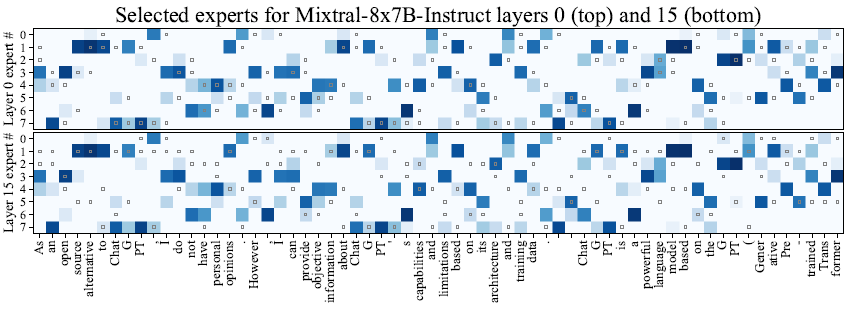

In [4]:
from IPython.display import Image, display

# Display an image by its filename
display(Image(filename=HOME+'/images/mixtral-experts.png'))

### **2.1. LRU caching**
We can see that some experts are reused more often than others. So they can be kept in the GPU for future use. If they are being activated again they will be immediately available from the cache. The cache stores $k$- number experts and when $k$ exceeds the number of the active experts, from the cache will be removed the least recently used experts. A simple strategy significantly increasing the inference from Mixtral-9x7B.

### **2.2. Speculative expert loading**

Unlike the fully connected (dense) models, Mixture-of-Expert MLP layers models can't decide which expert to load while the previous layer is still running and can't load it preliminary. This is incorporated in their manner of choosing active experts using the final outputs of the previous layer. Authors solve this limitation by speculatively guessing and loading the next layer while processing the previous. If the guess is right it speeds next layer inference, if not it loads the next layer’s experts later. This technique doesn't change the output but reduces the latency if the guess is correct. An accurate guess is made by applying next layer’s gating function to previous layer’s hidden states.

## **3. Design and implementation**

The system design and implementation combines caching and quatization techniques.

### **Quantization**

The method uses Half Quadratic Quantization - a quantization technique decoupling the problem with the model accuracy loss in two simpler problems. The primary goal is to optimize the trade-off between fidelity to the original signal and the simplicity or compactness achieved through quantization. The optimization problem is formulated with an objective function that includes a term for fidelity to the original signal and a term for the quantization error as seen in the formula below:

The optimization problem is defined as:

$$
\text{argmin}_{z, W_c} \Phi(W_e) + \frac{\beta}{2} \|W_e - (W - Q_z^{-1}(Q_z(W)))\|_2^2
$$

Sub-problems which are solved via alternate optimization:

$$
\text{(Sp1)} \quad W_e^{(t+1)} \leftarrow \text{argmin}_{W_e} \Phi(W_e) + \frac{\beta^{(t)}}{2} \|W_e - (W - Q_z^{-1}(Q_z(W)))\|_2^2
$$

$$
\text{(Sp2)} \quad z^{(t+1)} \leftarrow \text{argmin}_z \frac{1}{2} \|Q_z^{-1}(Q_z(W)) - (W - W_e^{(t+1)})\|_2^2
$$

$$
\beta^{(t+1)} \leftarrow \kappa\beta^{(t)},
$$

Where $Φ(We​)$ is a function of $We$​, which could represent some form of loss or cost associated with the expert weights. The second term is a regularization term that penalizes the difference between the expert weights $We$​ and the original weights $W$ after being quantized by $Qz$​ and then de-quantized by $Qz−1​$. The parameter $β$ controls the strength of this regularization.

### **Expert offloading**

As explained in 2.1. LRU cache is used for expert offloading with $k=2$ for 12 GB GPU and $k=4$ for 16GB GPU. 1-2 most likely exprets are loaded but they do not replace the currently loaded, and if a speculative expert is used later, it will replace the least recently used one. When an expert is loaded to the GPU the system o moves the least recently used expert back to RAM. The system has a buffer shared between all MoE layer to reduce memory usage.

## **4. Experiments**

To validate their hypothesis, the scientists conducted several experiments  on Mixtral-8x7B and Mixtral-8x7B-Instruct for:

- Measuring the effectiveness of expert caching
- Comparison between different model compression algorithms
- Measuring the inference latency on different hardware

### **4.1. Measuring the effectiveness of expert caching**

The LRU caching and and speculative loading are validated with a metric "expert recall" - how often when an expert is called for inference was already in the GPU. The experiment is conducted with Mixtral-8x7B-Instruct model on the OpenAssistant dataset.  

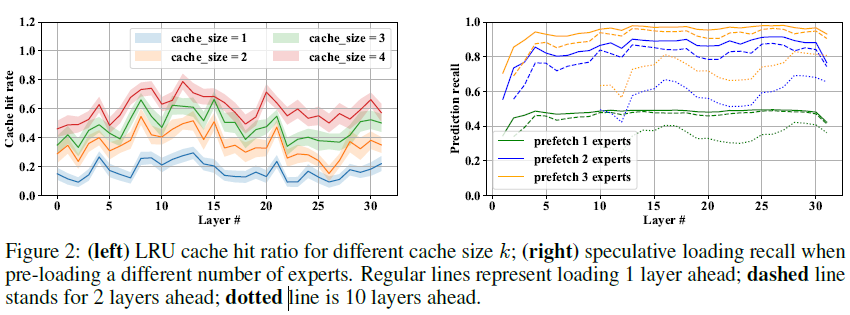

In [6]:
from IPython.display import Image, display

# Display an image by its filename
display(Image(filename=HOME+'/images/mixtral-experiment-1.png'))

**Left** - True positive hits for different $k$

**Right** - True positive in guessing which expert should be loaded

### **4.2. Comparing different model compression algorithms**

Testing how different quatization schemes affect the performance of MoE with metrics:

- Perpliexity over WikiText2 dataset containing 100 million tokens extracted from the set of verified Good and Featured articles on Wikipedia
- Perplexity over C4 (Colossal Clean Crawled Corpus) dataset crawled from Internet and cleaned with over 400M tokens
- 5-shot MMLU accuracy covering 57 tasks including elementary mathematics, US history, computer science

The results show an advantage to quantize experts to 3 or 2 bits while keeping attention layers to a higher bitwidth (16 or 4 bits)
  
 

### **4.3. Measuring the inference latency on different hardware**

Experiments with Mixtral8x7B-Instruct with 4-bit HQQ quantization. The hardware configurations which are used ar as follows:
- a free-tier Colab instance with a T4 GPU (16GB VRAM, PCIe Gen.3)
- a past generation gaming laptop with RTX 3080 Mobile (16GB, PCIe Gen.4)
- a midrange gaming desktop with RTX 3060 (12GB, PCIe Gen.3)
- a high-end data-center server with A100-80GB-SXM.

Results are shown in the table below:

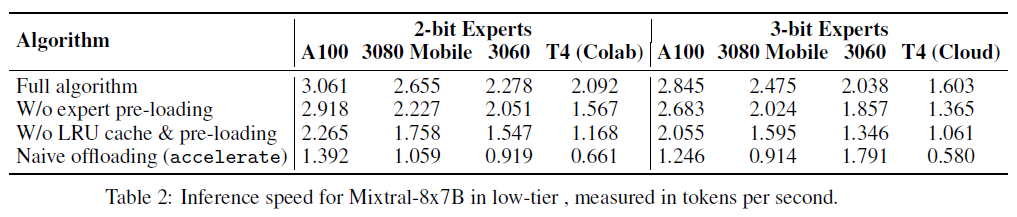

In [7]:
from IPython.display import Image, display

# Display an image by its filename
display(Image(filename=HOME+'/images/mixtral-hardware.png'))

## **5. Code reproduction**

### Install and import libraries

In [1]:
# fix numpy in colab
import numpy
from IPython.display import clear_output

# fix triton in colab
!export LC_ALL="en_US.UTF-8"
!export LD_LIBRARY_PATH="/usr/lib64-nvidia"
!export LIBRARY_PATH="/usr/local/cuda/lib64/stubs"
!ldconfig /usr/lib64-nvidia

!git clone https://github.com/dvmazur/mixtral-offloading.git --quiet
!cd mixtral-offloading && pip install -q -r requirements.txt
!huggingface-cli download lavawolfiee/Mixtral-8x7B-Instruct-v0.1-offloading-demo --quiet --local-dir Mixtral-8x7B-Instruct-v0.1-offloading-demo

clear_output()

In [2]:
import sys

sys.path.append("mixtral-offloading")
import torch
from torch.nn import functional as F
from hqq.core.quantize import BaseQuantizeConfig
from huggingface_hub import snapshot_download
from IPython.display import clear_output
from tqdm.auto import trange
from transformers import AutoConfig, AutoTokenizer
from transformers.utils import logging as hf_logging

from src.build_model import OffloadConfig, QuantConfig, build_model

hqq_aten package not installed. HQQBackend.ATEN backend will not work unless you install the hqq_aten lib in hqq/kernels.


/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


## Initialize model

In [3]:
model_name = "mistralai/Mixtral-8x7B-Instruct-v0.1"
quantized_model_name = "lavawolfiee/Mixtral-8x7B-Instruct-v0.1-offloading-demo"
state_path = "Mixtral-8x7B-Instruct-v0.1-offloading-demo"

config = AutoConfig.from_pretrained(quantized_model_name)

device = torch.device("cuda:0")

##### Change this to 5 if you have only 12 GB of GPU VRAM #####
offload_per_layer = 4
# offload_per_layer = 5
###############################################################

num_experts = config.num_local_experts

offload_config = OffloadConfig(
    main_size=config.num_hidden_layers * (num_experts - offload_per_layer),
    offload_size=config.num_hidden_layers * offload_per_layer,
    buffer_size=4,
    offload_per_layer=offload_per_layer,
)


attn_config = BaseQuantizeConfig(
    nbits=4,
    group_size=64,
    quant_zero=True,
    quant_scale=True,
)
attn_config["scale_quant_params"]["group_size"] = 256


ffn_config = BaseQuantizeConfig(
    nbits=2,
    group_size=16,
    quant_zero=True,
    quant_scale=True,
)
quant_config = QuantConfig(ffn_config=ffn_config, attn_config=attn_config)


model = build_model(
    device=device,
    quant_config=quant_config,
    offload_config=offload_config,
    state_path=state_path,
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/720 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torch/nn/init.py:452: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


Loading experts:   0%|          | 0/32 [00:00<?, ?it/s]

## Run the model

In [4]:
from transformers import TextStreamer


tokenizer = AutoTokenizer.from_pretrained(model_name)
streamer = TextStreamer(tokenizer, skip_prompt=True, skip_special_tokens=True)
past_key_values = None
sequence = None

seq_len = 0
while True:
  print("User: ", end="")
  user_input = input()
  print("\n")

  user_entry = dict(role="user", content=user_input)
  input_ids = tokenizer.apply_chat_template([user_entry], return_tensors="pt").to(device)

  if past_key_values is None:
    attention_mask = torch.ones_like(input_ids)
  else:
    seq_len = input_ids.size(1) + past_key_values[0][0][0].size(1)
    attention_mask = torch.ones([1, seq_len - 1], dtype=torch.int, device=device)

  print("Mixtral: ", end="")
  result = model.generate(
    input_ids=input_ids,
    attention_mask=attention_mask,
    past_key_values=past_key_values,
    streamer=streamer,
    do_sample=True,
    temperature=0.9,
    top_p=0.9,
    max_new_tokens=512,
    pad_token_id=tokenizer.eos_token_id,
    return_dict_in_generate=True,
    output_hidden_states=True,
  )
  print("\n")

  sequence = result["sequences"]
  past_key_values = result["past_key_values"]

tokenizer_config.json:   0%|          | 0.00/1.46k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/72.0 [00:00<?, ?B/s]

User: Write me a poem about Deep Learning


Mixtral: In the depths of data, vast and wide,
A mystery lies, a secret to be deciphered,
A neural network, like a brain,
To learn and grow, and perform, in strain.

Deep learning, a powerful tool,
In the hands of the clever,
A way to find patterns, make sense of speech,
Images, and more, as within their reach.

Through layers of nodes, they traverse,
Activation functions, they dive,
Learning from the errors they make,
To adjust the weights, and the game, they play.

Convolutions, pooling, and dropouts,
Helping to prevent overfitting,
Regularization, a must,
To keep the model lean and not bust.

Backpropagation, the engine of the train,
Going gradients, down the slope,
Updating the weights, ever so slightly,
Til the model learns, to perform so brightly.

Deep learning, a journey so grand,
From pixels to mastery, in the land,
Of computer vision, natural language,
Is where this tool, truly takes the stage.

A new era of AI, has come,
Thanks to 

KeyboardInterrupt: Interrupted by user